<a href="https://colab.research.google.com/github/jjzsilva9/vico/blob/main/VICO_Week_1_Practical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#VICO Week 1 Practical: An introduction to images, meshes and perspective projection

We're going to make use of quite a few different libraries in VICO. Today we'll be using numpy, matplotlib and OpenCV and also a library for reading 3D meshes in PLY format. The following code block installs and imports what we need and also downloads an image and mesh to the session storage for use later.

In [1]:
# Imports, dependencies and file downloads

# Install ply reader
!pip install plyfile

# Download an image
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/6/6f/York_Minster_from_M%26S.JPG/440px-York_Minster_from_M%26S.JPG


# Download a mesh in ply format
!wget https://people.sc.fsu.edu/~jburkardt/data/ply/shark.ply

import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
from plyfile import PlyData, PlyElement

--2024-09-27 12:39:54--  https://upload.wikimedia.org/wikipedia/commons/thumb/6/6f/York_Minster_from_M%26S.JPG/440px-York_Minster_from_M%26S.JPG
Resolving upload.wikimedia.org (upload.wikimedia.org)... 103.102.166.240, 2001:df2:e500:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|103.102.166.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46801 (46K) [image/jpeg]
Saving to: ‘440px-York_Minster_from_M&S.JPG’

440px-York_Minster_ 100%[===================>]  45.70K  --.-KB/s    in 0.07s   

2024-09-27 12:39:55 (692 KB/s) - ‘440px-York_Minster_from_M&S.JPG’ saved [46801/46801]

--2024-09-27 12:39:55--  https://people.sc.fsu.edu/~jburkardt/data/ply/shark.ply
Resolving people.sc.fsu.edu (people.sc.fsu.edu)... 144.174.0.22
Connecting to people.sc.fsu.edu (people.sc.fsu.edu)|144.174.0.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25817 (25K)
Saving to: ‘shark.ply’

shark.ply           100%[===================>]  2

Now let's load an image using OpenCV (there are various other tools for reading an image - e.g. PIL and matplotlib).

In [2]:
# Load image using OpenCV
img = cv2.imread('440px-York_Minster_from_M&S.JPG')
print('Image dimensions:',img.shape)
print('Image datatype:',img.dtype)

Image dimensions: (330, 440, 3)
Image datatype: uint8


So far, so easy. We can see that `cv2.imread` has returned a numpy array of size 330 pixels high, 440 pixels wide and with three colour channels. We can also see that the values in the image are 8 bit unsigned integers. This is the most common way to store an image and means that, for each pixel, you will have three numbers in the range 0..255 representing the intensity for each colour channel.

Just one thing to note: OpenCV made the bizarre decision to use the convention that colour channels are ordered: blue, green, red (BGR) rather than the much more common convention: red, green, blue (RGB). If you're using any other library to process colour images, you probably need to convert to RGB. This is easy to do. Let's do that and then display the image using matplotlib.

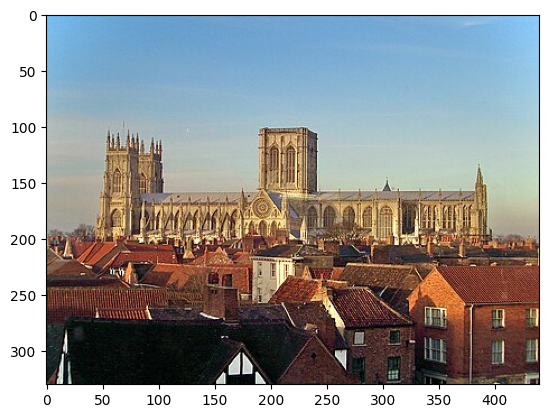

In [3]:
# Convert BGR to RGB
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# Display image
plt.imshow(img_rgb)

For clarity, we can now index values in the image as `img_rgb[row,column,colour_channel]` so that, for example, the red, green and blue values at the top left pixel are:

In [4]:
print('Red value at pixel (0,0):',img_rgb[0,0,0])
print('Green value at pixel (0,0):',img_rgb[0,0,1])
print('Blue value at pixel (0,0):',img_rgb[0,0,2])

Red value at pixel (0,0): 115
Green value at pixel (0,0): 191
Blue value at pixel (0,0): 243


Representing image data as integers in the range 0..255 is not a good idea when we want to start to manipulate the values in some way. First of all, the use of integers will introduce rounding errors that will accumulate over multiple operations. Second, the choice of 255 is arbitrary. Therefore, we often want to convert image data to floating point values in the range 0..1 with 0 representing no light and 1 the maximum that can be recorded/displayed. This conversion is easily achieved with:

In [5]:
img2 = img_rgb.astype('float32')/255

Now, we can apply arbitrary maths to the pixel values in our image. For example, we can linearly scale the values by 2, giving an image that is twice as bright:

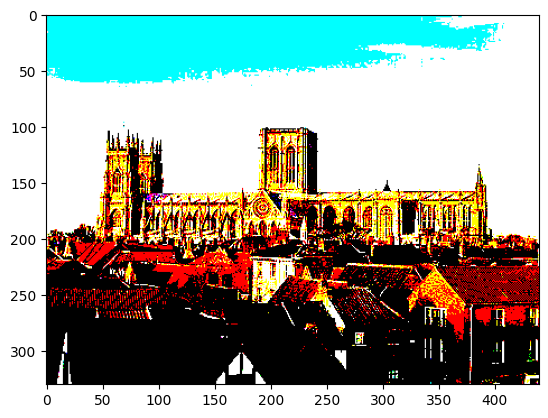

In [26]:
ret, thresh = cv2.threshold(img2, 0.5, 1, cv2.THRESH_BINARY)
plt.imshow(thresh, cmap='gray')

The warning message is interesting here. Because we multiplied by 2, we now have values that are >1. `imshow` "clips" these values to 1, i.e. it uses min(img_rgb,1). This simulates "saturation" in a camera. It can't record anymore light than 1. As each colour channel reaches 1, you end up with (1,1,1) for the three colour channels which means white. Hence, the blue sky has turned white.

###Task 1: manipulating images

Do some more experimentation. Try scaling by different values and observe what happens. How about if you scale each colour channel by a different value? What does the image look like if, at each pixel, the value is the same for the three colour channels? (e.g. you might copy the red channel into green and blue, or take the average over the three channels). Can you think why it looks like this? What does it look like if you set two of the colour channels to zero?

Take a look through this [OpenCV tutorial](https://docs.opencv.org/4.x/d3/df2/tutorial_py_basic_ops.html) which goes over some of the above plus a bit more.

Finally, can you *threshold* the image? This means turning an image into a binary image. For example, you might want to threshold the red channel on 0.5. So values $<0.5$ get set to 0 and $\geq 0.5$ get set to 1. To display such an image with imshow, you might want to pass `cmap='gray'` to get the expected appearance.

##Projecting and drawing meshes

The following code block loads a 3D triangle mesh containing `nvertices` vertices and `nfaces` triangle faces. Vertices are stored in the 3 $\times$ `nvertices` numpy array `V`. So `V[:,0]` contains the 3D position of the first vertex. Faces are stored in the `nfaces` $\times$ 3 numpy array `F`. The three vertex indices for the first triangle are stored in `F[0,:]`. Putting those together, the 3D coordinates of the first vertex in the first triangle would be given by `V[:,F[0,:]]`.

In [126]:
plydata = PlyData.read('shark.ply')

nvertices = len(plydata['vertex'])
nfaces = len(plydata['face'])

# Copy vertex positions into numpy array
V = np.empty((3,nvertices))
V[0,:] = plydata['vertex']['x']
V[1,:] = plydata['vertex']['y']
V[2,:] = plydata['vertex']['z']

F = np.vstack(plydata['face'].data['vertex_indices'])

###Task 2: perspective projection

Now I would like you to compute the perspective projection of the vertices of the mesh into 2D (you can ignore the faces for now - we're just treating it like a point cloud). I've given you the intrinsic and extrinsic camera parameters to perform a reasonable projection into an image that is 500 pixels wide and 326 pixels tall. You need to look up the perspective projection equation in the slides for video lecture 3 and write some code to apply it to `V` using the `K`, `R` and `t` matrices I've given. Hint: remember that you need to use homogeneous coordinates for the 3D vertices, do the matrix multiplications, then homogenise.

The code at the end of the block will plot the point cloud. It should be recognisable if you manage it!

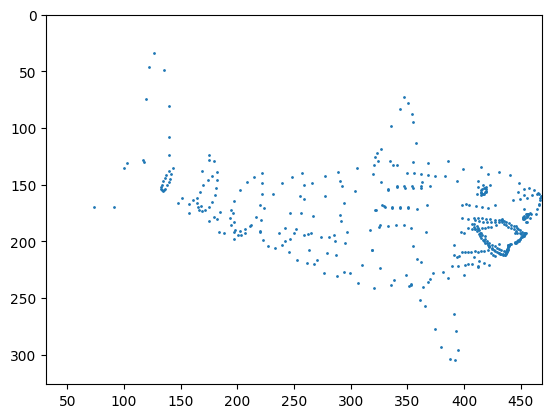

In [127]:
R = np.array([[0.9063, 0.0, 0.4226], [0.0, -1.0000, 0.0], [0.4226, 0, -0.9063]]) # Rotation of camera
t = np.array([[1.0350], [0.3861], [15.0140]]) # Position of camera
K = np.array([[2000.0,0.0,250.0],[0.0,2000.0,163.0],[0.0,0.0,1.0]]) # Reoffset of world to pixel coordinates

# Perform perspective projection
# Your code goes here:

t = np.r_[t, [np.array([1])]]
R = np.r_[R,[np.array([0, 0, 0])]]
RtMatrix = [R, t]
RtMatrix = np.concatenate(RtMatrix, axis=1)

K = np.append(K, np.array([[0], [0], [0]]), axis=1)

V = np.r_[V,[np.array([1] * 468)]]
u = K@(RtMatrix@V)

# Plot projected 2D point cloud
fig, ax = plt.subplots()
ax.scatter(u[0,:]/u[2,:], u[1,:]/u[2,:], s=1)
ax.axis('equal')
ax.set(xlim=(0, 500), ylim=(0, 326))
plt.gca().invert_yaxis()
plt.show()

###Task 3: working with triangles

Next, I'd like you to draw it as a wireframe. In other words, you should draw a line in 2D for every triangle edge. To draw a line from `(x1,y1)` to `(x2,y2)` just use `ax.plot([x1,x2],[y1,y2])`. You might want to play with some parameters of `plot` to make the wireframe look nice. I've started you off with a loop over triangles. For each triangle you're going to draw three lines in 2D using the projected vertex positions `u[0,:]` and `u[1,:]` that you computed above.

In [128]:
u[0:2] = u[0:2]/u[2]

In [129]:
print(u.shape)

(3, 468)


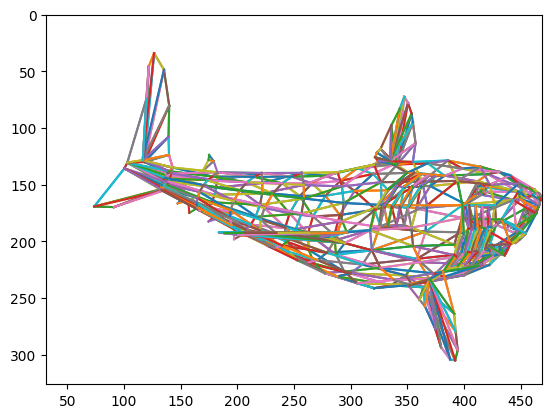

In [130]:
# Draw wireframe
fig, ax = plt.subplots()
for i in range(nfaces):
  # Draw the three triangle edges
  # Your code goes here:
  facePoints = F[i]
  plot1x = [u[0][facePoints[0]], u[0][facePoints[1]]]
  plot1y = [u[1][facePoints[0]], u[1][facePoints[1]]]
  plot2x = [u[0][facePoints[1]], u[0][facePoints[2]]]
  plot2y = [u[1][facePoints[1]], u[1][facePoints[2]]]
  plot3x = [u[0][facePoints[2]], u[0][facePoints[0]]]
  plot3y = [u[1][facePoints[2]], u[1][facePoints[0]]]
  ax.plot(plot1x, plot1y)
  ax.plot(plot2x, plot2y)
  ax.plot(plot3x, plot3y)
ax.axis('equal')
ax.set(xlim=(0, 500), ylim=(0, 326))
plt.gca().invert_yaxis()
plt.show()

The observant amongst you may have noticed that the above code is wasteful. Edges are shared between triangles so every edge will have been draw twice. There are algorithms for extracting a list of unique edges from a triangle list. If you are inspired, go and find one of those algorithms and implement it!

###Task 4: projection parameters

Now that you have code for projecting a mesh to 2D and displaying it in 2D, try playing with some of the parameters. I carefully chose $\mathbf{K}$, $\mathbf{R}$ and $\mathbf{t}$ so that the model is in a nice pose and fits exactly in the image.

First try playing with the focal length, i.e. elements $(1,1)$ and $(2,2)$ in $\mathbf{K}$ (remember that when we talk about element positions in matrices we give them as (row,column) indices and start from 1 even though our python code will use zero indexing). Try making it bigger and smaller. What happens? How about if the two focal length values are not equal? Next, what happens if you change $c_x$ and $c_y$? (elements $(1,3)$ and $(2,3)$ in $\mathbf{K}$).

Second try playing with the extrinsic parameters. Can you rotate the object around the vertical axis? (You'll need to apply a y axis rotation to your vertices). For extra challenge, can you find out how to do an animation in matplotlib and get the mesh to continuously rotate?

Finally, you might like to experiment with some other meshes. [This page](https://people.sc.fsu.edu/~jburkardt/data/ply/ply.html) has loads in PLY format.